### Imports 

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import  CSVLogger
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Activation,  Flatten, Dense
from tensorflow.keras.initializers import RandomNormal
import os 

strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1


### Check which device is selected for training

I recommend to use GPU or TPU for training. 


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(f"Number of GPUs available: {len(gpus)}")
    print("Using GPU for training.")
else:
    print("No GPUs available. Using CPU for training.")


No GPUs available. Using CPU for training.


In [3]:
device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "GPU")
 
# Printing the DeviceSpec 
print('Device Spec: ', device_spec.to_string())

Device Spec:  /job:localhost/replica:0/device:GPU:*


### Parameters for dataset

In [22]:
batch_size = 64
img_size = (128,128)

### Load dataset

In [23]:
def show_images(images, num_images=16):
    images = (images + 1.0) / 2.0  # Denormalize to range [0, 1]
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

(64, 128, 128, 3)


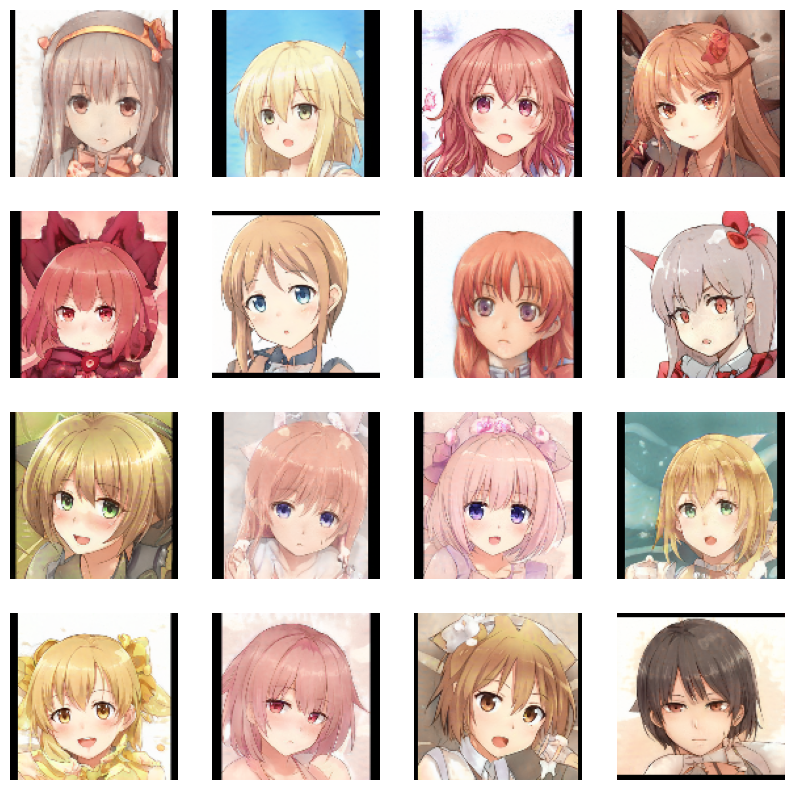

In [24]:
class AnimeDataset(tf.data.Dataset):
    """Custom data loader class inheriting from tf.data.Dataset."""
    def __new__(cls, img_dir, batch_size=32, img_size=(128, 128)):
        # Construct absolute paths to the images
        path_list = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)
        img_list = [os.path.join(abspath, path) for path in path_list if path.lower().endswith('.png')]
        
        # Load and preprocess images using TensorFlow operations
        def load_and_preprocess_image(path):
            img = tf.io.read_file(path)
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, img_size)
            img = (img - 127.5) / 127.5  # Normalize images to [-1, 1]
            return img
        
        # Map loading and preprocessing across the dataset
        dataset = tf.data.Dataset.from_tensor_slices(img_list)
        dataset = dataset.map(lambda x: load_and_preprocess_image(x),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

        return dataset

 
# img_dir = '/kaggle/input/out2/'   
img_dir='images/'
with strategy.scope():
    dataset = AnimeDataset(img_dir, img_size=img_size, batch_size=batch_size)

# To check the dataset
for batch in dataset.take(1):
    print(batch.shape)
    show_images(batch.numpy())

### Generator Model

In [9]:
def build_generator():
    model = tf.keras.models.Sequential()
    
    # Initial dense layer
    model.add(layers.Dense(8 * 8 * 1024 , use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    input_channels = img_size[0]
    # Reshape into a feature map of size 8x8 with 256 channels
    model.add(layers.Reshape((8, 8, 1024)))
    
    #  8x8x1024 --> 16x16x512
    model.add(layers.Conv2DTranspose(input_channels * 4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 16x16x512 --> 32x32x256
    model.add(layers.Conv2DTranspose(input_channels  * 2, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # 32x32x256 --> 64x64x128
    model.add(layers.Conv2DTranspose(input_channels, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
     # 64x64x128 --> 128x128x64
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Upsampling to 64x64
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    
    return model

 
# Initialize generator
with strategy.scope():
    generator = build_generator()

# Display summary
generator.summary()

c:\Users\vinew\anaconda3\envs\anime_gan\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 65536)          │     6,553,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65536)          │       262,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 512)    │    13,107,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 64)   │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 3)    │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,232,384 (92.44 MB)

 Trainable params: 24,099,392 (91.93 MB)

 Non-trainable params: 132,992 (519.50 KB)

### Discriminator Model

In [10]:
def build_discriminator():
    
    inputs = Input(shape=(128, 128, 3))

    # First convolutional block
    x = Conv2D(64, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), use_bias=False)(inputs)
    x = LeakyReLU(negative_slope=0.2)(x)
    
    # Second convolutional block
    x = Conv2D(128, kernel_size=5, strides=2, padding='same', use_bias=False,
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    
    # Additional convolutional blocks
    x = Conv2D(256, kernel_size=5, strides=2, padding='same', use_bias=False,
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)

    x = Conv2D(512, kernel_size=5, strides=2, padding='same', use_bias=False,
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(negative_slope=0.2)(x)

    x = Conv2D(1, kernel_size=4, strides=1, padding='valid', use_bias=False,
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = Flatten()(x)

    # Logits and sigmoid output
    logits = Dense(1, activation=None, name='logits')(x)
    outputs = Activation('sigmoid')(logits)

    model = Model(inputs=inputs, outputs=outputs)
    return model


with strategy.scope():
    discriminator = build_discriminator()

 
discriminator.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       204,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │     3,276,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 1)        │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (None, 1)              │            26 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,317,402 (16.47 MB)

 Trainable params: 4,315,610 (16.46 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Extract logits. 

In [11]:
logits_model = tf.keras.Model(inputs=discriminator.input, outputs=discriminator.get_layer('logits').output)

### Hyper parameters for training 

In [26]:
criterion = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Create a batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = tf.random.normal([batch_size, 100, 1, 1])

epochs = 3 # 215 recomend
 
real_label = 1.0
fake_label = 0.0

clipvalue = 1.0 
# Setup Adam optimizers for both G and D
lr_D = 0.0001
lr_G = 2e-4 # Learning rate
beta1 = 0.5  # First moment decay rate
LAMBDA = 10
with strategy.scope(): 
    optimizerD = tf.optimizers.Adam(learning_rate=lr_D, beta_1=beta1, beta_2=0.999 , clipvalue= clipvalue)
    optimizerG = tf.optimizers.Adam(learning_rate=lr_G, beta_1=beta1, beta_2=0.999, clipvalue=clipvalue)

### Define loss function

In [33]:
with strategy.scope(): 
        def calculate_loss( output, labels):
                criterion = tf.keras.losses.BinaryCrossentropy(from_logits=False)
                return criterion(labels, output)
with strategy.scope(): 
        def real_loss( d_logits, d_model):
                
                return  tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits,
                                                     labels=tf.ones_like(d_model)))
    
with strategy.scope(): 
       def fake_loss( d_logits, d_model):
                
                return  tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits,
                                                     labels=tf.zeros_like(d_model)))
with strategy.scope(): 
        def noise( ):
                z = tf.random.uniform(minval=-1, maxval=1, shape=(batch_size,100))
                return tf.convert_to_tensor(z, dtype=tf.float32)
        
with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
                loss = tf.reduce_mean(tf.abs(real_image - same_image))
                return LAMBDA * 0.5 * loss

### Create a DCGAN model class

In [41]:
class DCGan(keras.Model):
    def __init__(
        self,
        anime_generator,
        anime_discriminator,
       
    ):
        
        super(DCGan, self).__init__()
        self.anime_generator = anime_generator
        self.anime_discriminator = anime_discriminator


    def compile(
            self,
            discriminator_optimazer,
            generator_optimazer,
            noise ,
            real_loss,
            fake_loss,
            logits_model = logits_model,
           
    ):
        super(DCGan,self).compile()
        self.discriminator_optimazer = discriminator_optimazer
        self.generator_optimazer = generator_optimazer
        self.real_loss = real_loss
        self.fake_loss = fake_loss 
        self.noise = noise
        self.logits_model = logits_model
         
 
    
    def train_generator(self, g_optim):
         
        with tf.GradientTape() as tape:
            
            z = self.noise()
             
            fake_images = self.anime_generator(z)
            
            d_fake = self.anime_discriminator(fake_images)
            d_fake_logits = self.logits_model(fake_images)
            g_loss = self.real_loss(d_fake_logits, d_fake)

            g_loss = g_loss 
        
        gradients = tape.gradient(g_loss, self.anime_generator.trainable_variables)
        
        g_optim.apply_gradients(zip(gradients, self.anime_generator.trainable_variables))

        return g_loss 
    
    def train_discriminator(self, disc_opt, real_image): 

        with tf.GradientTape() as tape:
            
             
            real_img = self.anime_discriminator(real_image)
            d_reak_loss = self.logits_model(real_image)
            real_losses = self.real_loss(d_reak_loss, real_img)

            random_noise = self.noise()

            fake_img = self.anime_generator(random_noise)

            d_fake = self.anime_discriminator(fake_img)
            d_fake_logits = self.logits_model(fake_img)

            d_fake_loss = self.fake_loss(d_fake_logits , d_fake)

            d_loss = real_losses + d_fake_loss

            d_loss = d_loss * 0.5

        gradients = tape.gradient(d_loss, self.anime_discriminator.trainable_variables)
        disc_opt.apply_gradients(zip(gradients, self.anime_discriminator.trainable_variables))

        return d_loss 

    

    def train_step(self, data):
        real_images = data
         
        
         
        d_loss = self.train_discriminator(self.discriminator_optimazer, real_images)
         
        g_loss = self.train_generator(self.generator_optimazer)
        
        return {'discriminator_loss': d_loss, 'generator_loss': g_loss}
        
         

### Create Custom checkpoints
It help us to save the weights for discriminator and generator during the training

In [42]:
class CustomModelCheckpoint(Callback):
    def __init__(self, save_freq, checkpoint_dir, checkpoint):
        super(CustomModelCheckpoint, self).__init__()
        self.save_freq = save_freq
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint = checkpoint

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            file_path = os.path.join(self.checkpoint_dir, f'generator_12_{self.checkpoint + epoch + 1}.weights.h5')
            self.model.anime_generator.save_weights(file_path)
            file_path = os.path.join(self.checkpoint_dir, f'discriminator_12_{self.checkpoint + epoch + 1}.weights.h5')
            self.model.anime_discriminator.save_weights(file_path)
            print(f'\nModel saved to {file_path}')

### Create and Compile DCGAN model instance 

In [43]:
with strategy.scope():

    DCGAN_M = DCGan(anime_discriminator=discriminator, anime_generator=generator)
    DCGAN_M.compile(
         discriminator_optimazer = optimizerD,
         generator_optimazer = optimizerG,
         real_loss = real_loss,
         fake_loss = fake_loss, 
         noise = noise,
         logits_model = logits_model
    )

### Initialize checkpoint object and csv logger

In [44]:
checkpoint_dir = '/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

custom_checkpoint_callback = CustomModelCheckpoint(save_freq=1, checkpoint_dir=checkpoint_dir, checkpoint=checkpoint)
 
csv_logger = CSVLogger('training_16_log.csv', append=True)



In [45]:
checkpoint = 0
if checkpoint != 0: 
    discriminator.load_weights(f"./checkpoints/discriminator_{checkpoint}.h5")
    generator.load_weights(f"./checkpoints/generator_{checkpoint}.h5")

In [ ]:
DCGAN_M.fit(
    dataset,
    epochs=epochs-checkpoint,   
    callbacks=[custom_checkpoint_callback , csv_logger] 
)

### Test the generator

#### Load checkpoints 

In [49]:
generator.load_weights('./checkpoints/generator_12_228.weights.h5')

In [56]:
def generate_random_noise(batch_size, noise_dim):
    z = tf.random.uniform(minval=-1, maxval=1, shape=(batch_size,100))
    return tf.convert_to_tensor(z, dtype=tf.float32)

# Function to generate and visualize samples
def generate_and_visualize_samples(generator, num_samples):
    
    
    # Generate images using the generator model
    generated_images = generator.predict(fixed_noise)
    
    # Check the shape of generated images
    print("Generated images shape:", generated_images.shape)
    
    # Rescale images from [-1, 1] to [0, 1]
    generated_images = 0.5 * generated_images + 0.5
    
    # Plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(8, 8, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [57]:
noise_dim = 100
num_samples = 32

In [64]:
fixed_noise =  generate_random_noise(num_samples, noise_dim)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Generated images shape: (32, 128, 128, 3)


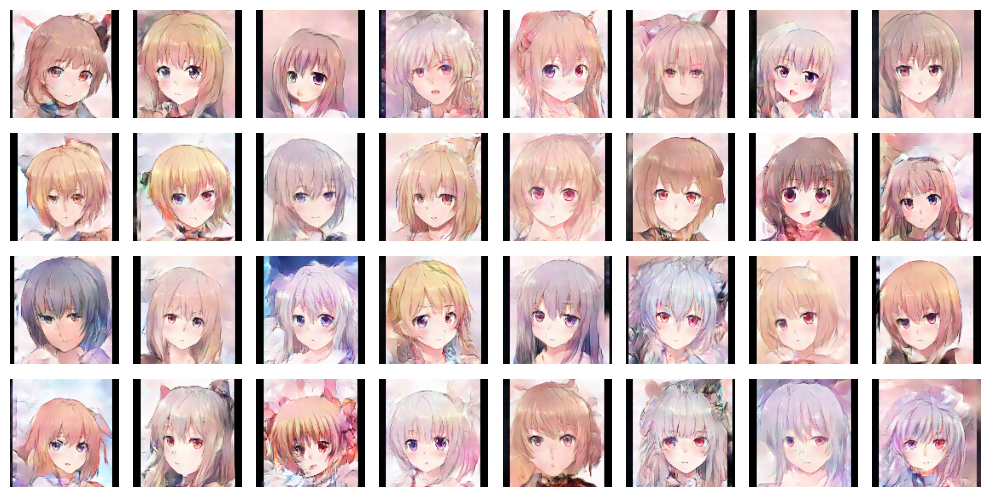

In [65]:
generate_and_visualize_samples(generator, num_samples)